In [38]:
import os
from pathlib import Path
import sys
import numpy as np
import scvelo as scv
notebook_dir = os.getcwd()
os.chdir(Path(notebook_dir).parents[1])
import sys  
sys.path.insert(1,'/home/sergio/Jnotebooks/SALMON/github_repo/SALMON/stvelo/')
from pipelines.simulate_3ode import *
from pipelines.metrics import *
from pipelines.preprocessing import Preprocessing
from pipelines.compute_velocity import Velocities

# Input 

In [39]:
saving_adata_path='/home/sergio/Jnotebooks/SALMON/datasets/simulated_data/'
saving_plots_path='/home/sergio/Jnotebooks/SALMON/datasets/simulated_data_plots/'

In [40]:
n_cells=800
n_genes=300
t_max=20 #### maybe could be fix?
mu = np.array([3, 1.8, 0.8, 0.5])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

############## CONFIG PREPROCESSING #####################
config_preprocessing = {'preprocess_params': { 'min_counts': 200, 'min_cells': 5, 'n_neighbors': 23, 'n_pcs': 0, 'min_dist': 1},
'functions_to_apply': {'filter_cells': True,  'filter_genes': True,   'normalize_total': True,  'log1p': True,
'pca': True,   'neighbors': True,   'umap': True,   'leiden': True,   'moments': True}}

############## CONFIG VELOCITY #####################
config_velocity = { 'velocity_types': ['deterministic']}


# Simulation

In [4]:
cov = C * R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size = n_genes).T)
s = switch_times(20,300)

In [61]:
adata_dict = simulation_3ode(n_obs=n_cells,alpha=alpha, beta= beta, nu=nu, gamma=gamma, t_max=t_max, switches=s/20,n_vars=n_genes,
                            noise_level=5)

# Spatial artifacts would go here

# Preprocessing

In [62]:
for key, adata in adata_dict.items():
    print(f'{key} is being preprocessed.')
    preprocessor = Preprocessing(adata,config_preprocessing)
    adata = preprocessor.preprocess_data()

adata_s_u is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
adata_n_c is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Velocities

In [63]:
velocity_computer = Velocities(adata_dict,config_velocity)
adata_dict_velocity = velocity_computer.compute_velocities()

Using device: cpu
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# This will be implemented into a function (basic plotting)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


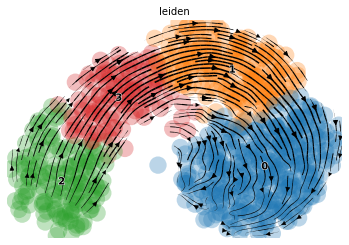

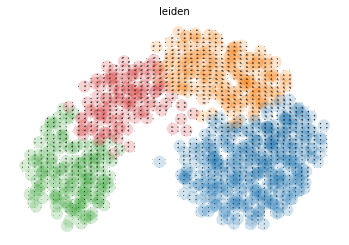

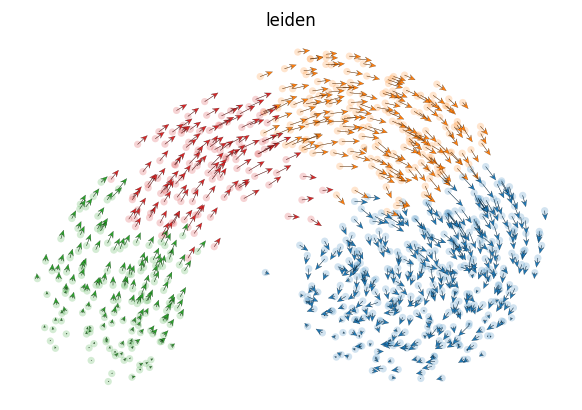

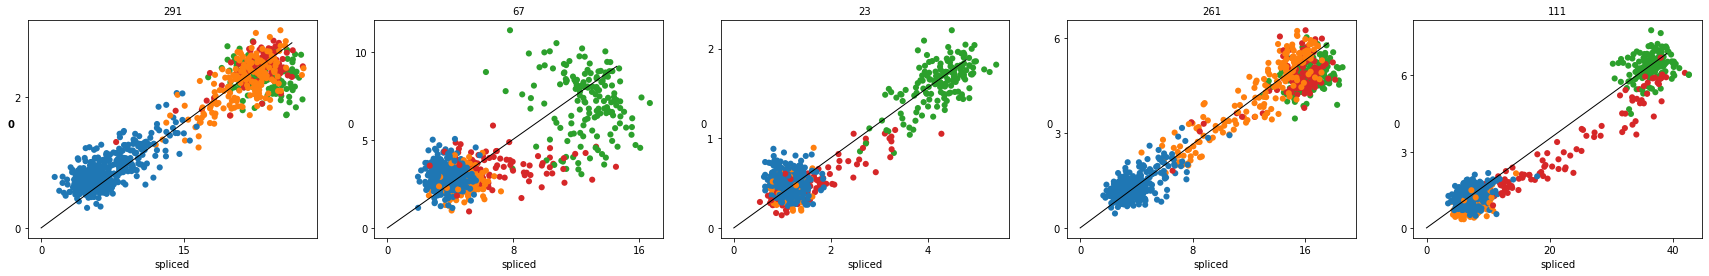

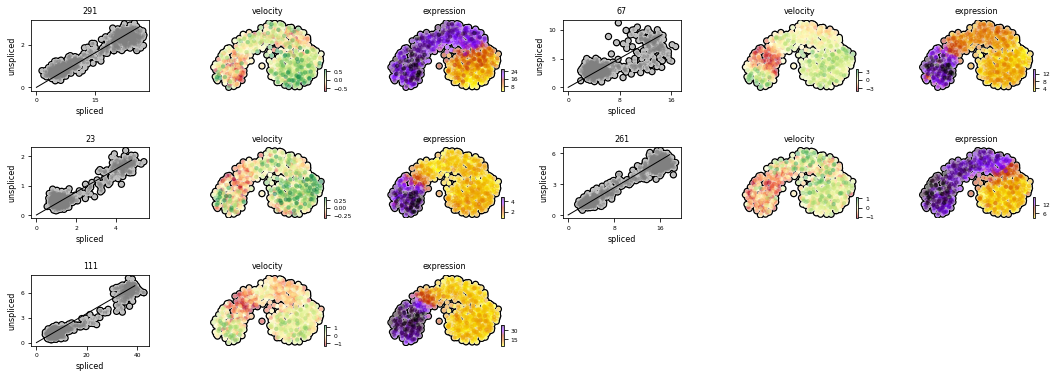

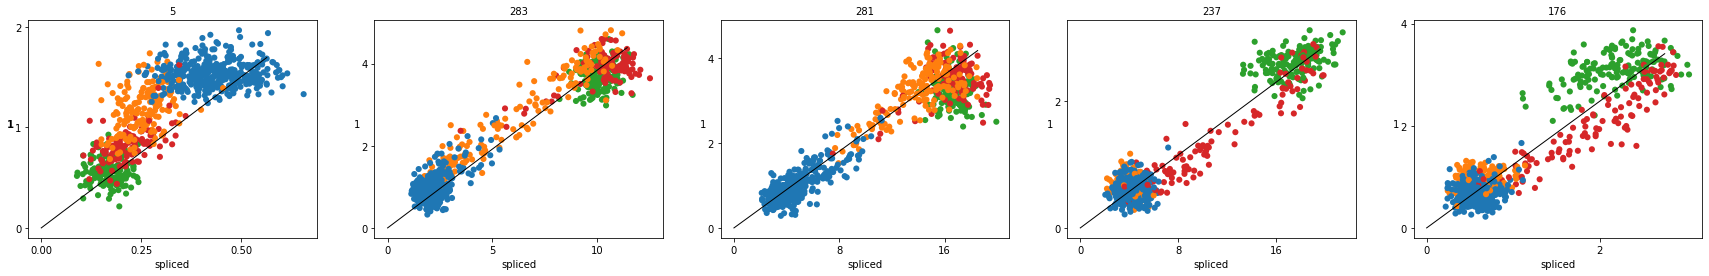

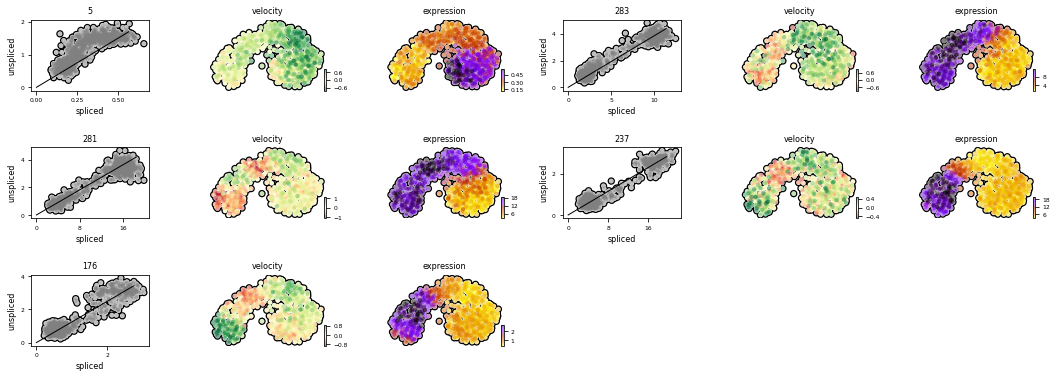

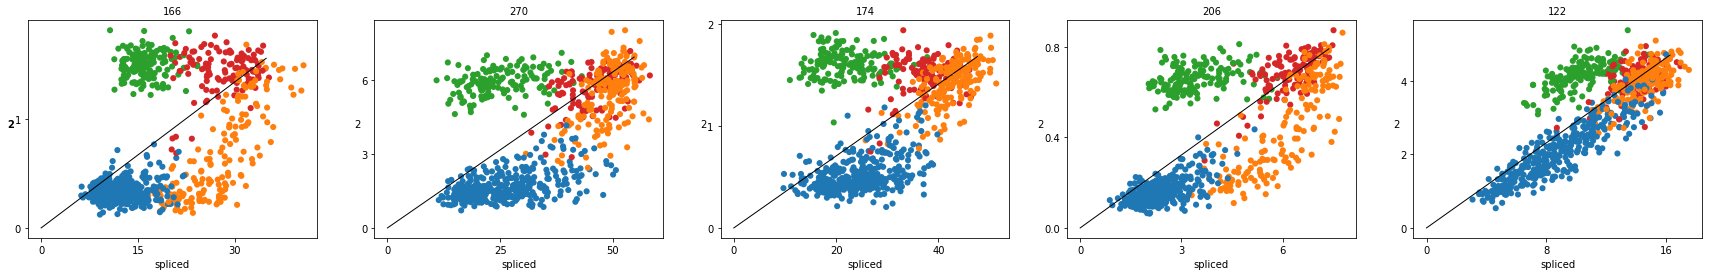

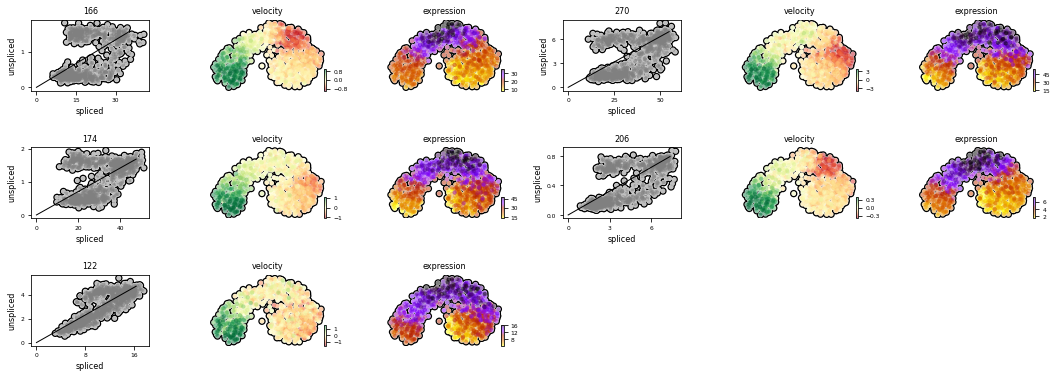

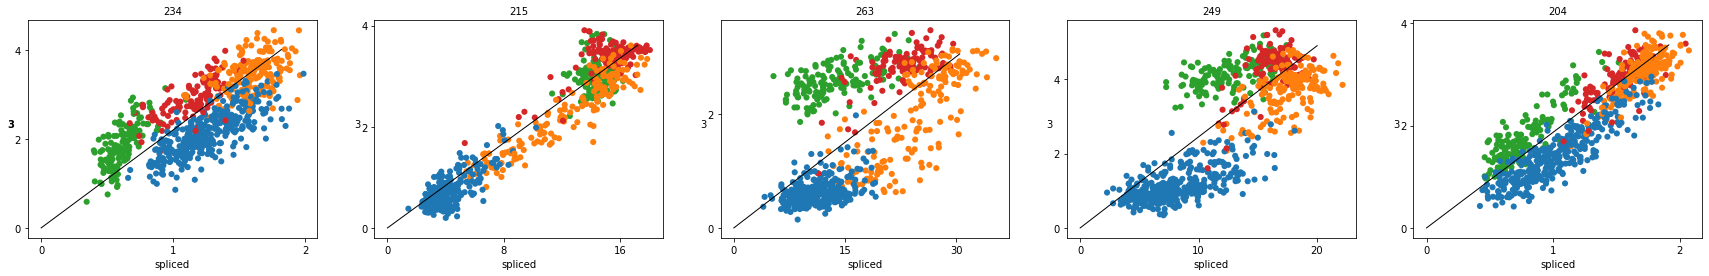

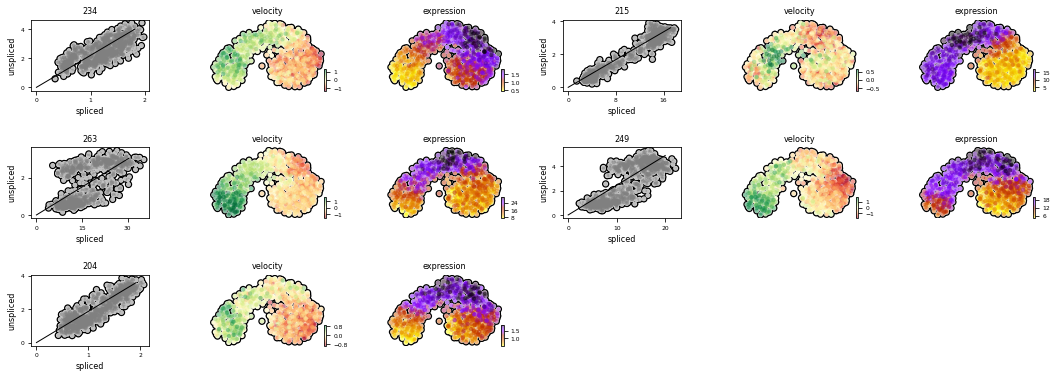

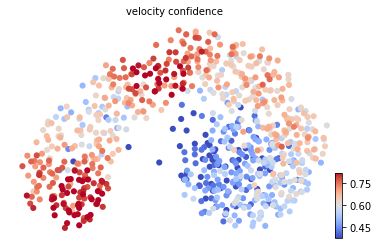

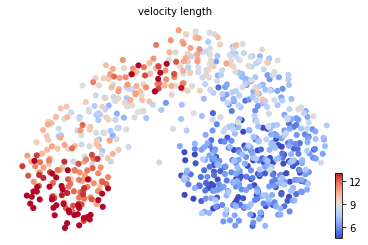

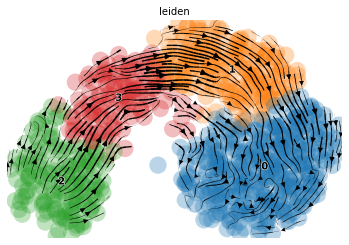

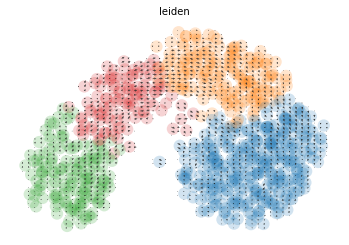

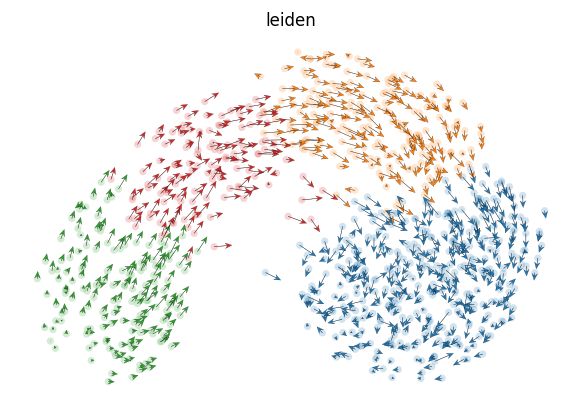

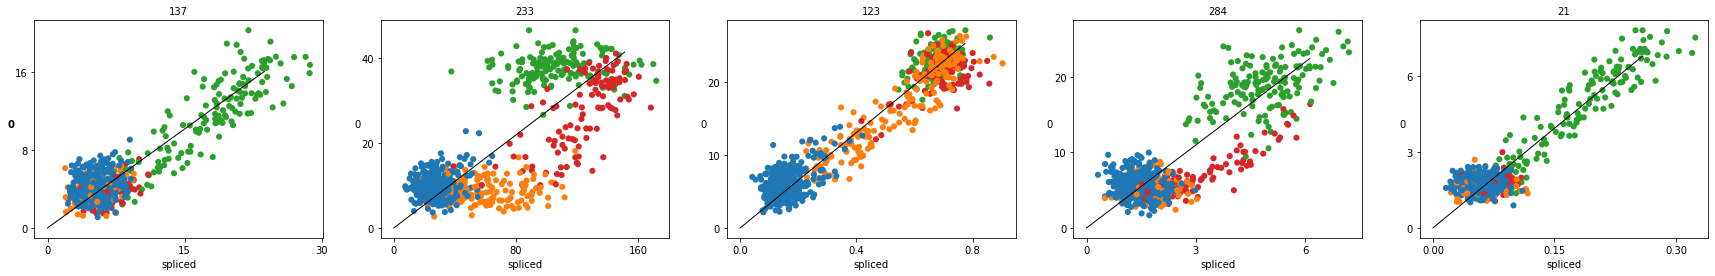

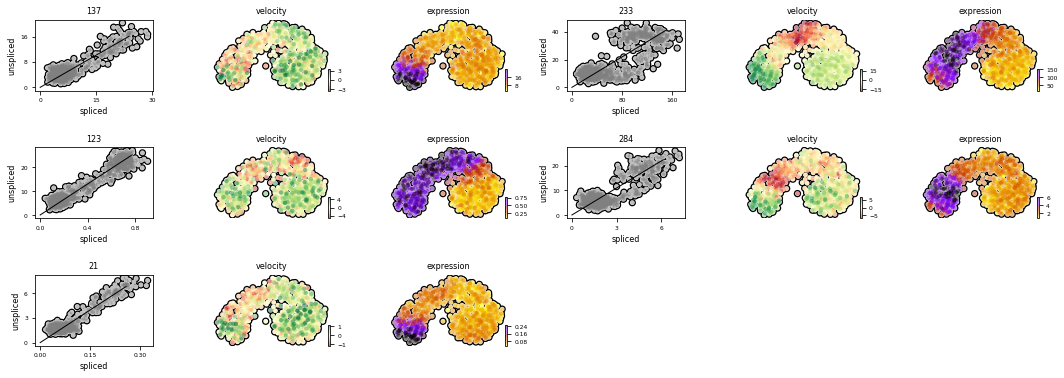

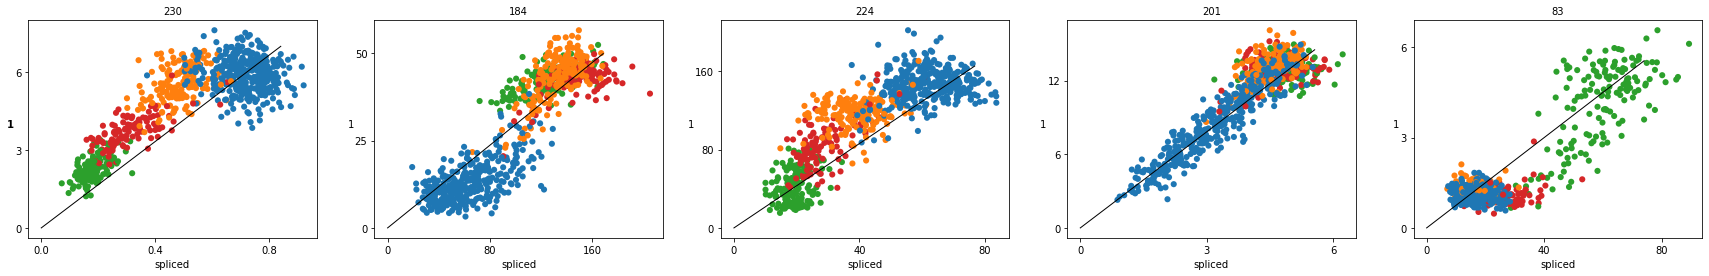

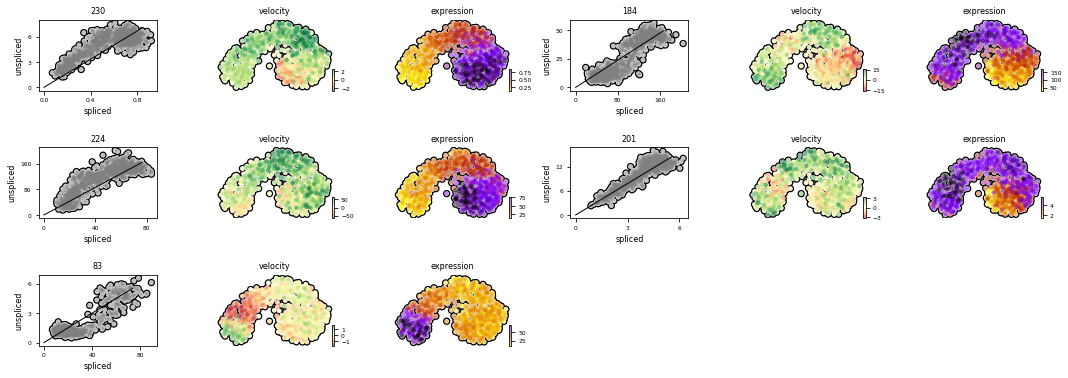

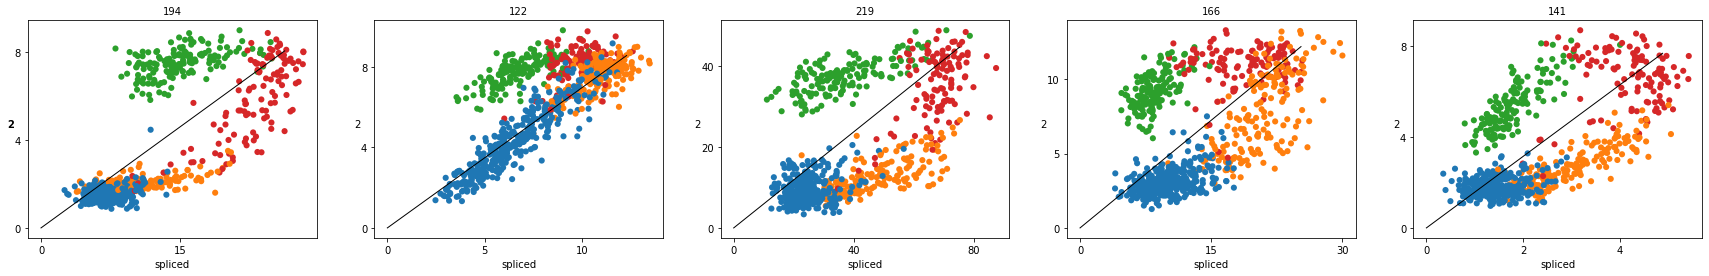

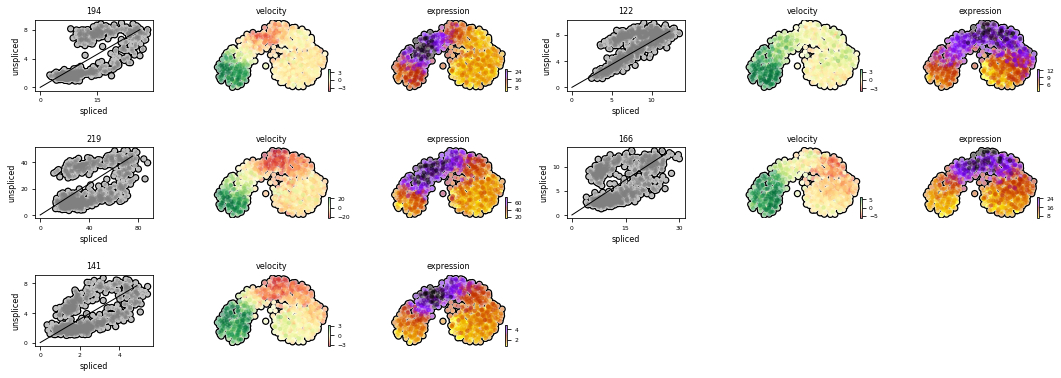

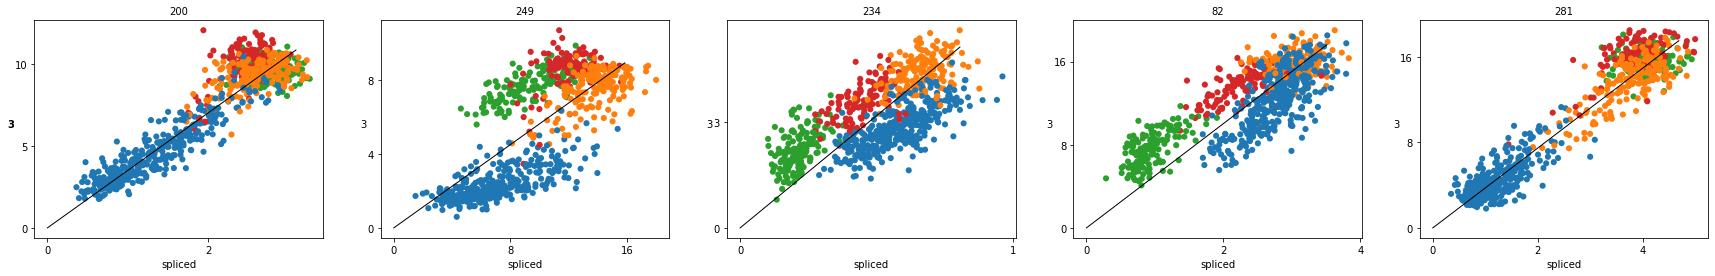

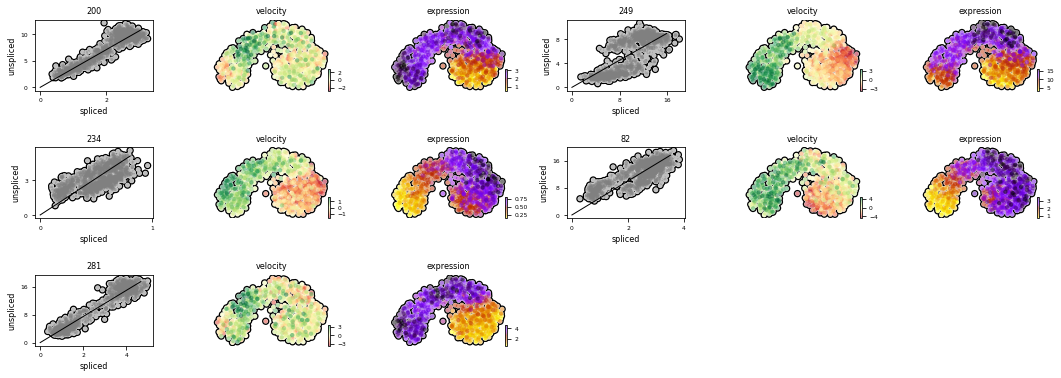

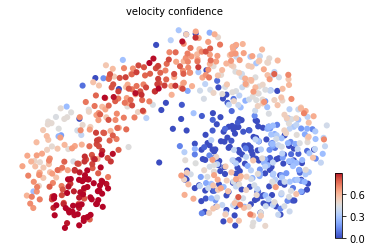

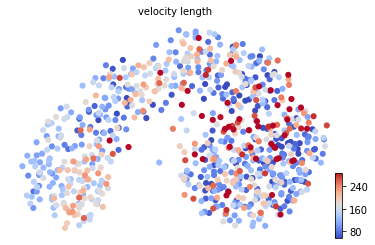

In [64]:
import os 
if not os.path.exists(saving_plots_path):
    os.mkdir(saving_plots_path)
for d in adata_dict_velocity.keys():
    adata=adata_dict_velocity[d]
    saving_adata_path=os.path.join(saving_plots_path,d)
    if not os.path.exists(os.path.join(saving_plots_path,d)):
        os.mkdir(os.path.join(saving_plots_path,d))
    sets=['leiden']
    for colorset in sets:
        try:
            scv.pl.velocity_embedding_stream(adata, basis='umap',color=colorset,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_stream.svg'.format(colorset)))
            scv.pl.velocity_embedding_grid(adata, basis='umap',color=colorset,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_grid.svg'.format(colorset)))
            scv.pl.velocity_embedding(adata, arrow_length=3,color=colorset, arrow_size=2, dpi=120,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_embedding.svg'.format(colorset)))
        except:
            pass
    ####
    scv.tl.rank_velocity_genes(adata, groupby='leiden', min_corr=.3)
    df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
    for col in df.columns:
        scv.pl.scatter(adata, df[col][:5], ylabel=col,color='leiden',show=False)
        plt.savefig(os.path.join(saving_adata_path,'scatterplot_velo_{}.svg'.format(col)))
        scv.pl.velocity(adata, df[col][:5], ncols=2, add_outline=True,show=False)
        plt.savefig(os.path.join(saving_adata_path,'velocity_plots_{}.svg'.format(col)))
    scv.tl.velocity_confidence(adata)
    scv.pl.scatter(adata, c='velocity_confidence', cmap='coolwarm', perc=[5, 95],show=False)
    plt.savefig(os.path.join(saving_adata_path,'umap_confidence.svg'))
    scv.pl.scatter(adata, c='velocity_length', cmap='coolwarm', perc=[5, 95],show=False)
    plt.savefig(os.path.join(saving_adata_path,'umap_velocity_length.svg'))

# Save results (if needed)

In [65]:
for d in adata_dict_velocity.keys():
    print(d)
    adata_dict_velocity[d].write(os.path.join(saving_adata_path,d+'.h5ad'))

adata_s_u_deterministic
adata_n_c_deterministic


# Performance metrics (this should also be a function, tbd)

In [66]:
# confidence 
for d in adata_dict_velocity.keys():
    print(d)
    adata_dict[d]=compute_confidence(adata_dict_velocity[d])
    
#velocity correlations (by gene or by cell)
velo_corr_bygene=velocity_mean_correlation(adata_dict_velocity,mode='by_gene')
velo_corr_bycell=velocity_mean_correlation(adata_dict_velocity,mode='by_cell')

# velocity corr against a reference 
velocity_correlation_by_gene=velocity_corr_against_reference(adata_dict_velocity,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_correlation_by_cell=velocity_corr_against_reference(adata_dict_velocity,reference='adata_s_u_deterministic', mode= 'by_cell')

#velo mse 
velo_mse_bygene=velocity_mean_mse(adata_dict_velocity,mode='by_gene')
velo_mse_bycell=velocity_mean_mse(adata_dict_velocity,mode='by_cell')

# velo mse against a reference 
velocity_mse_by_gene=velocity_mse_against_reference(adata_dict_velocity,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_mse_by_cell=velocity_mse_against_reference(adata_dict_velocity,reference='adata_s_u_deterministic', mode= 'by_cell')

adata_s_u_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
adata_n_c_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


In [68]:
# velocity sign
sign_accuracies=get_sign_accuracy(adata_dict_velocity)


adata_s_u_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5766.44it/s]


adata_n_c_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5703.61it/s]


# Plotting metrics

<Axes: xlabel='Velocity confidence', ylabel='velo_type'>

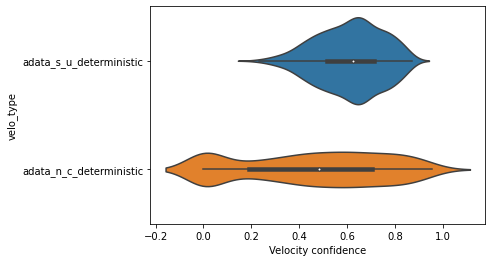

In [70]:
# confidence
import seaborn as sns
confidences=get_confidences(adata_dict_velocity)
sns.violinplot(data=confidences,x='Velocity confidence',y='velo_type')

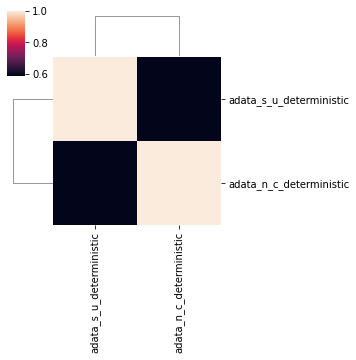

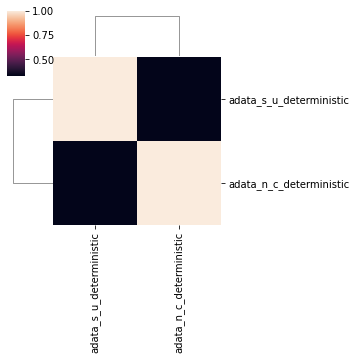

In [71]:
# velocity correlations (by gene or by cell)
sns.clustermap(velo_corr_bygene.astype(float),figsize=(5,5))
sns.clustermap(velo_corr_bycell.astype(float),figsize=(5,5))

Text(0.5, 0, 'Correlation against reference')

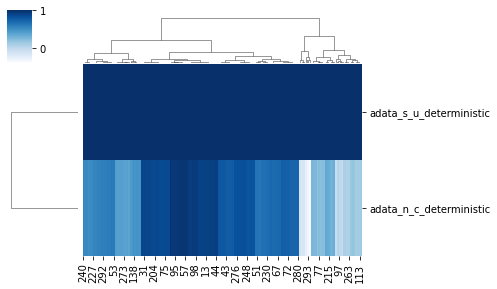

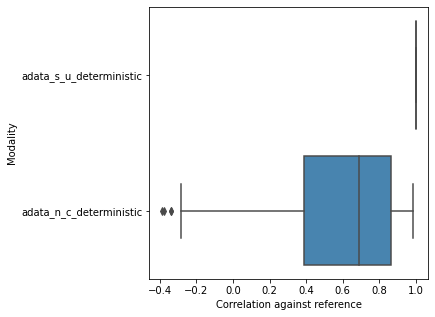

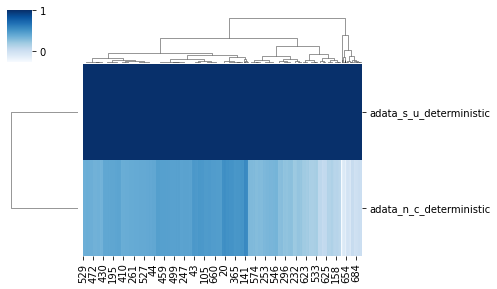

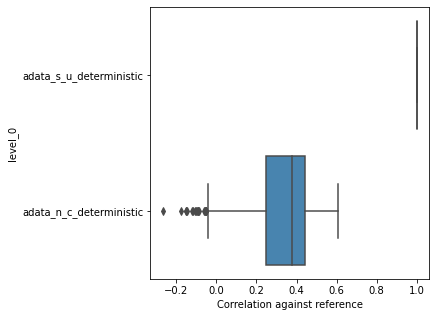

In [72]:
# velocity corr against a reference 
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_gene.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_gene.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')
plt.ylabel('Modality')

# same, but by cell
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_cell.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_cell.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')


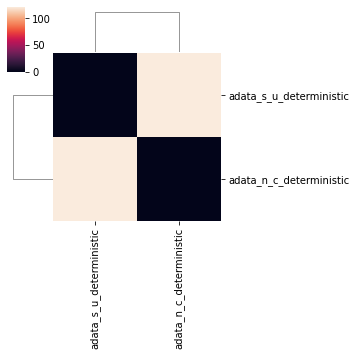

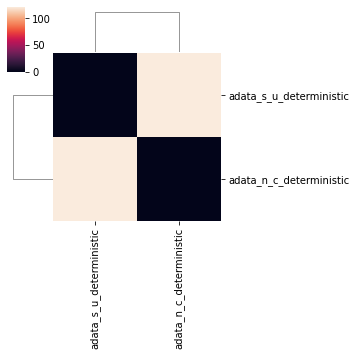

In [73]:
# velo mse
sns.clustermap(velo_mse_bygene.astype(float),figsize=(5,5))
sns.clustermap(velo_mse_bycell.astype(float),figsize=(5,5))

Text(0, 0.5, 'Modality')

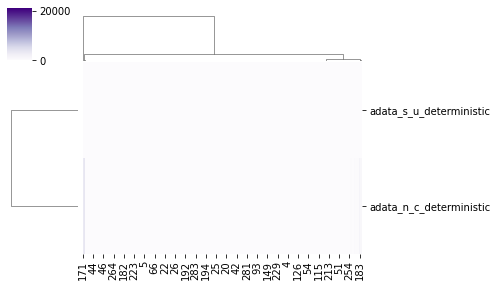

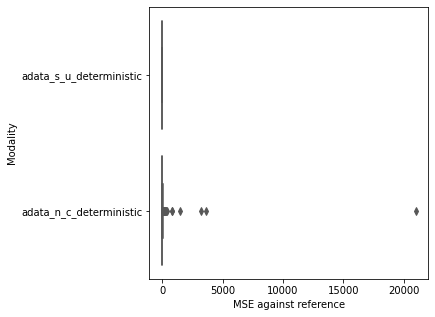

In [74]:
# velo mse against reference 
import matplotlib.pyplot as plt
sns.clustermap(velocity_mse_by_gene.fillna(0),figsize=(7,4),cmap='Purples')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_mse_by_gene.stack().reset_index(),y='level_0',x=0,palette='Purples')
plt.xlabel('MSE against reference')
plt.ylabel('Modality')


<Axes: xlabel='Accuracy', ylabel='Model'>

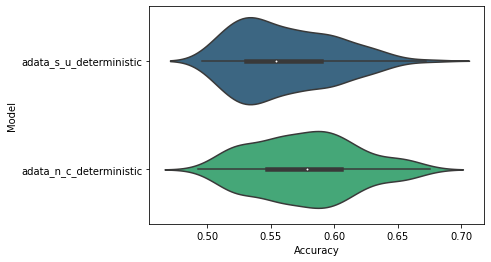

In [75]:
# plotting velocity signs
sns.violinplot(data=sign_accuracies,y='Model',x='Accuracy',palette='viridis')

# Metrics in development

In [79]:
import numpy as np
import pandas as pd
import scvelo as scv
from scvi.utils import track
from joblib import Parallel, delayed
import logging
logger = logging.getLogger(__name__)
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union
#from velovi._model import _compute_directional_statistics_tensor

def _compute_directional_statistics_tensor(
    tensor: np.ndarray, n_jobs: int, n_cells: int
) -> pd.DataFrame:
    df = pd.DataFrame(index=np.arange(n_cells))
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    logger.info("Computing the uncertainties...")
    
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(tensor[:, cell_index, :])
        for cell_index in range(n_cells))
    
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [
        results[i][1] for i in range(n_cells)
    ]
    df.loc[:, "directional_cosine_sim_difference"] = [
        results[i][2] for i in range(n_cells)
    ]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims

def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [
        _cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)
    ]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def compute_extrinsic_uncertainty(adata, n_samples=25) -> pd.DataFrame:
    """
    Computes extrinsic uncertainty based on the velocity and spliced RNA data in the adata object.
    
    Args:
        adata: AnnData object with velocity and spliced RNA data.
        n_samples: Number of samples for extrapolation.

    Returns:
        pd.DataFrame: Dataframe with directional statistics, representing extrinsic uncertainty.
    """
    extrapolated_cells_list = []
    
    for i in track(range(n_samples)):
        # Use the precomputed velocity from adata (since we don't have vae)
        vkey = f"velocities_velovi_{i}"
        adata.layers[vkey] = adata.layers['velocity']  # Reuse precomputed velocity
        
        # Compute the velocity graph with the given velocity data
        scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
        
        # Get the transition matrix T(v_1:N, s_1:N)
        t_mat = scv.utils.get_transition_matrix(
            adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
        )
        
        # Multiply the transition matrix by the spliced RNA matrix to get the future state
        extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
        
        # Store each sample's extrapolated cells
        extrapolated_cells_list.append(extrapolated_cells)
    
    # Stack all the extrapolated cells from different samples
    extrapolated_cells = np.stack(extrapolated_cells_list)
    
    # Compute the directional statistics (variance) as a measure of extrinsic uncertainty
    ext_uncertainty_df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=1, n_cells=adata.n_obs)
    #ext_uncertainty_df = compute_extrinsic_uncertainty(adata,n_samples=25)
    for c in ext_uncertainty_df[0].columns:
        adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[0][c].values)
    return adata

def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [90]:
adata.obs

true_t     n_counts leiden  velocity_self_transition  velocity_length  \
0      0.00   825.721136      2                  0.092328            10.94   
1      0.00  1035.904258      2                  0.230183             8.24   
2      0.01   936.678451      2                  0.032754            13.35   
3      0.03  1790.592961      3                  0.343449             8.41   
4      0.06   966.679262      2                  0.000000            15.11   
..      ...          ...    ...                       ...              ...   
795   19.92  1940.840260      0                  0.139413             8.38   
796   19.95   982.857200      0                  0.197026             6.61   
797   19.98  1223.803064      0                  0.233286             8.43   
798   19.99  1712.868629      0                  0.106791             6.65   
799   20.00  1243.672828      0                  0.208291             6.48   

     velocity_confidence  velocity_confidence_transition  Velocity confidence  \
0               0.435771                        0.443724             0.435771   
1               0.367298                        0.365342             0.367298   
2               0.577886                        0.514225             0.577886   
3               0.215621                        0.213309             0.215621   
4               0.757960                        0.582700             0.757960   
..                   ...                             ...                  ...   
795             0.415984                        0.401482             0.415984   
796             0.409943                        0.335741             0.409943   
797             0.230532                        0.299901             0.230532   
798             0.357735                        0.388668             0.357735   
799             0.483214                        0.328214             0.483214   

     velocities_velovi_0_self_transition  velocities_velovi_1_self_transition  \
0                               0.015075                             0.015075   
1                               0.062752                             0.062752   
2                               0.117905                             0.117905   
3                               0.217229                             0.217229   
4                               0.000000                             0.000000   
..                                   ...                                  ...   
795                             0.220178                             0.220178   
796                             0.021456                             0.021456   
797                             0.249243                             0.249243   
798                             0.174197                             0.174197   
799                             0.211947                             0.211947   

     ...  velocities_velovi_5_self_transition  \
0    ...                             0.015075   
1    ...                             0.062752   
2    ...                             0.117905   
3    ...                             0.217229   
4    ...                             0.000000   
..   ...                                  ...   
795  ...                             0.220178   
796  ...                             0.021456   
797  ...                             0.249243   
798  ...                             0.174197   
799  ...                             0.211947   

     velocities_velovi_6_self_transition  velocities_velovi_7_self_transition  \
0                               0.015075                             0.015075   
1                               0.062752                             0.062752   
2                               0.117905                             0.117905   
3                               0.217229                             0.217229   
4                               0.000000                             0.000000   
..                                   ...       

In [87]:
# Usage example:
# Assuming `adata` is already loaded with scvelo output
adata = compute_extrinsic_uncertainty(adata_dict_velocity['adata_s_u_deterministic'],n_samples=10)

Working...:   0%|                                                                                | 0/10 [00:00<?, ?it/s]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_0_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  10%|███████▏                                                                | 1/10 [00:01<00:10,  1.21s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_1_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  20%|██████████████▍                                                         | 2/10 [00:02<00:09,  1.22s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_2_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  30%|█████████████████████▌                                                  | 3/10 [00:03<00:08,  1.21s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_3_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  40%|████████████████████████████▊                                           | 4/10 [00:04<00:07,  1.23s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_4_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  50%|████████████████████████████████████                                    | 5/10 [00:06<00:06,  1.24s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_5_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  60%|███████████████████████████████████████████▏                            | 6/10 [00:07<00:05,  1.31s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_6_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  70%|██████████████████████████████████████████████████▍                     | 7/10 [00:08<00:03,  1.25s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_7_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  80%|█████████████████████████████████████████████████████████▌              | 8/10 [00:09<00:02,  1.25s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_8_graph', sparse matrix with cosine correlations (adata.uns)
Working...:  90%|████████████████████████████████████████████████████████████████▊       | 9/10 [00:11<00:01,  1.26s/it]computing velocity graph (using 1/32 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_9_graph', sparse matrix with cosine correlations (adata.uns)
Working...: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.2s


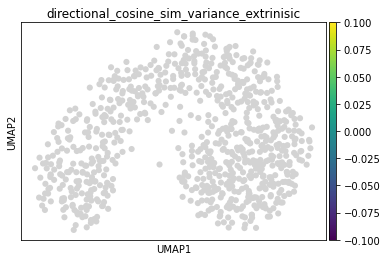

In [88]:
sc.pl.umap(adata, 
color="directional_cosine_sim_variance_extrinisic",vmin="p1", vmax="p99")

In [45]:
adata.layers['true_velocity']

KeyError: 'true_velocity'